In [28]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf

from data_import import *

##### Data Imports

In [4]:
data_importing = OregonProcess()
data_dict = data_importing.oregon_data_runner()

Selecting Oregonian rows: 100%|██████████| 3/3 [00:28<00:00,  9.36s/it]


saving Oregon data into new csvs


table saving: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Oregon data saved into csvs.


In [2]:
oregon_data_dict = oregon_import()

file import: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]


In [4]:
oregon_data_dict['test_timeseries'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26316 entries, 0 to 26315
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   fips         26316 non-null  int32         
 1   date         26316 non-null  datetime64[ns]
 2   PRECTOT      26316 non-null  float64       
 3   PS           26316 non-null  float64       
 4   QV2M         26316 non-null  float64       
 5   T2M          26316 non-null  float64       
 6   T2MDEW       26316 non-null  float64       
 7   T2MWET       26316 non-null  float64       
 8   T2M_MAX      26316 non-null  float64       
 9   T2M_MIN      26316 non-null  float64       
 10  T2M_RANGE    26316 non-null  float64       
 11  TS           26316 non-null  float64       
 12  WS10M        26316 non-null  float64       
 13  WS10M_MAX    26316 non-null  float64       
 14  WS10M_MIN    26316 non-null  float64       
 15  WS10M_RANGE  26316 non-null  float64       
 16  WS50

##### Drought Score Histograms

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


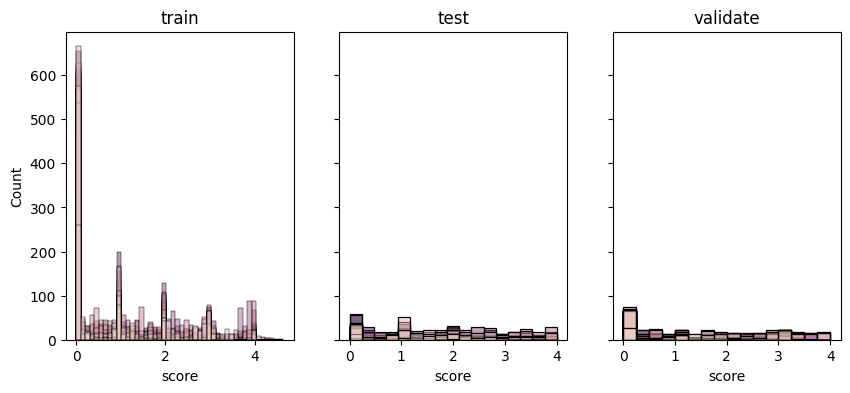

In [31]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(10,4))
sns.histplot(data=data_dict['train_timeseries'],x='score', hue = "fips", ax=ax[0])
sns.histplot(data=data_dict['test_timeseries'],x='score', hue = "fips", ax=ax[1])
sns.histplot(data=data_dict['validation_timeseries'],x='score', hue = "fips", ax=ax[2])
for axis in ax:
    axis.legend().remove()
ax[0].set_title('train')
ax[1].set_title('test')
ax[2].set_title('validate')
plt.show()

##### Washington County, Oregon values over time

In [21]:
train_copy = oregon_data_dict['train_timeseries'].copy()
wacounty = train_copy[train_copy['fips']==41067]

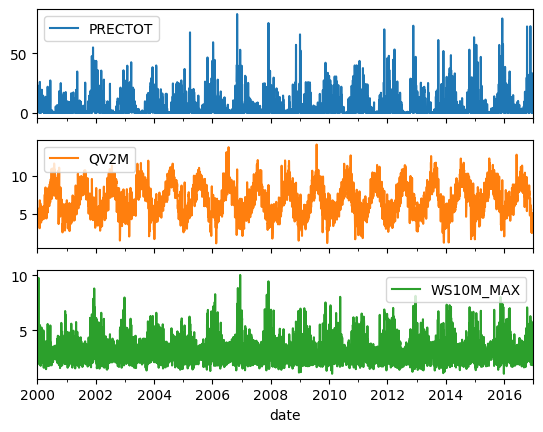

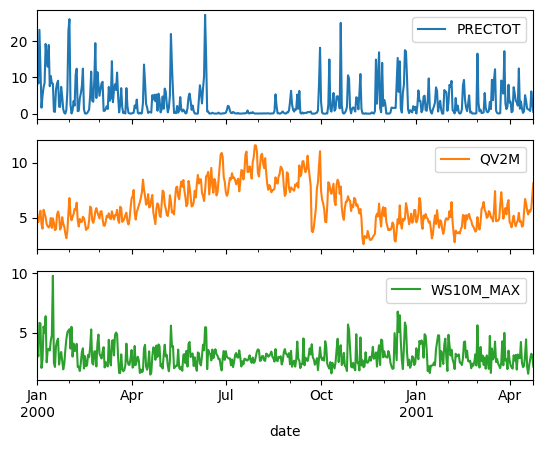

In [22]:
date_time = wacounty.loc[:,'date']
plot_cols = ['PRECTOT', 'QV2M', 'WS10M_MAX']
plot_features = wacounty[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = wacounty[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

##### Examining Periodicity of Values

In [24]:
train_copy = oregon_data_dict['train_timeseries'].copy()

In [25]:
day = 24*60*60
year = (365.2425)*day

# gets number of seconds since 1 January 1970:
timestamp = train_copy['date'].map(pd.Timestamp.timestamp)

train_copy['Year sin'] = np.sin(timestamp * (2 * np.pi / year))
train_copy['Year cos'] = np.cos(timestamp * (2 * np.pi / year))

We add year cos and year sin to account for how years are periodic and graph one years worth of values to verify the new variables were calculated correctly:

Text(0.5, 1.0, 'Time of year signal')

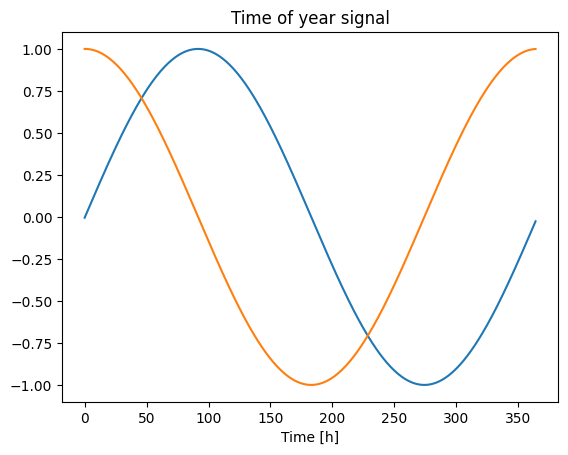

In [26]:
plt.plot(np.array(train_copy['Year sin'])[:365])
plt.plot(np.array(train_copy['Year cos'])[:365])
plt.xlabel('Time [h]')
plt.title('Time of year signal')

We use a Fourier Transform to examine the frequency of signals to look for any time-periodicity among the variables

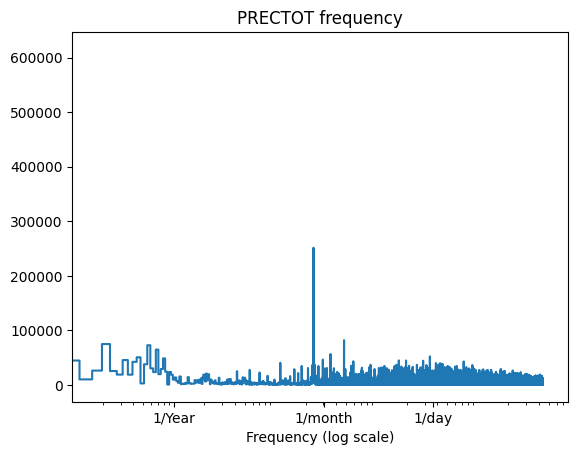

In [30]:
fft = tf.signal.rfft(train_copy['PRECTOT'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(train_copy['PRECTOT'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
# plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.title('PRECTOT frequency')
plt.xticks([1, 30.4, 365.2524], labels=['1/Year', '1/month', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

##### Examining Distributions & Normalization of Variables

In [32]:
train_copy.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
fips,223560.0,41036.0,41001.0,41018.5,41036.0,41053.5,41071.0,20.776636
date,223560,2008-07-01 12:00:00.000000256,2000-01-01 00:00:00,2004-04-01 00:00:00,2008-07-01 12:00:00,2012-10-01 00:00:00,2016-12-31 00:00:00,NaN
PRECTOT,223560.0,2.754398,0.0,0.02,0.28,2.64,121.24,6.082837
PS,223560.0,93.006201,81.44,87.62,93.59,98.05,102.13,5.12171
QV2M,223560.0,5.799131,0.69,4.2,5.59,7.28,14.55,2.11961
T2M,223560.0,9.042133,-19.47,3.58,8.78,14.65,32.79,7.345029
T2MDEW,223560.0,3.847163,-20.99,-0.1,4.24,8.29,19.29,5.875751
T2MWET,223560.0,3.869337,-20.36,-0.07,4.25,8.29,19.29,5.845624
T2M_MAX,223560.0,14.633524,-13.97,7.78,13.7,21.34,40.93,8.945559
T2M_MIN,223560.0,4.313178,-25.38,-0.15,4.67,9.18,25.42,6.236637


We then take a new copy without datetime column and without county codes to normalize and examine distribution of values.

In [31]:
train_copy_nt = train_copy.copy()
train_copy_nt.drop(columns=['date', 'fips'],inplace=True)

train_mean = train_copy_nt.mean()
train_std = train_copy_nt.std()

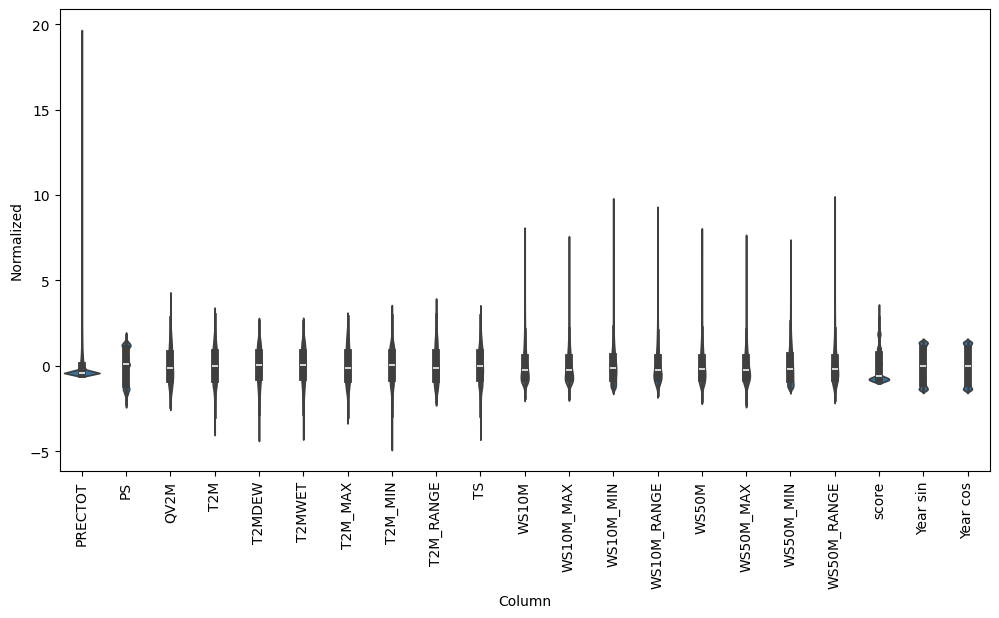

In [34]:
train_copy_nt_std = (train_copy_nt - train_mean) / train_std
train_copy_nt_std = train_copy_nt_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=train_copy_nt_std)
ax.tick_params("x", labelrotation=90)
# _ = ax.set_xticklabels(train_copy_nt.keys(), rotation=90)